# EhV

# Package imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [5]:
import joblib

import scipy.stats
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import fcluster
from xgboost import XGBClassifier
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.inspection import permutation_importance
from sklearn.metrics import balanced_accuracy_score

import pickle

In [6]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2/results/scip/202202071958/"

In [7]:
df = pq.read_table(data_dir / "features.parquet").to_pandas()
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)
df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"])
df = df[numpy.load(data_dir / "indices/columns.npy", allow_pickle=True)]
df = df.loc[numpy.load(data_dir / "indices/iso.npy", allow_pickle=True)]
df = df[df["meta_label"] != "unknown"]
df["meta_label"] = pandas.Categorical(df["meta_label"], categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)
df.shape

(103775, 914)

In [8]:
with open(data_dir / "rfe/xgb_features.txt", "r") as fh:
    selected = [col[len("scip_"):] for col in fh.read().split(",")]

In [9]:
df = pandas.concat([df.filter(regex="meta"), df[selected]], axis=1)

In [10]:
# selection of the generic channel features for SCIP
to_keep = df.filter(regex="feat.*(BF1|BF2|DAPI|SSC)$").columns
Xs = df.loc["Inf"][to_keep]
Xs.shape

(29731, 111)

In [11]:
y = df.loc["Inf"]["meta_label"]

In [12]:
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, stratify=y, test_size=0.1, random_state=0)

In [14]:
corr = scipy.stats.spearmanr(Xs_train).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
numpy.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - numpy.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

In [15]:
clusters = fcluster(dist_linkage, 0.5, criterion="distance").ravel().tolist()
indices = [clusters.index(c) for c in numpy.unique(clusters)]
features = [Xs_train.columns[i] for i in indices]

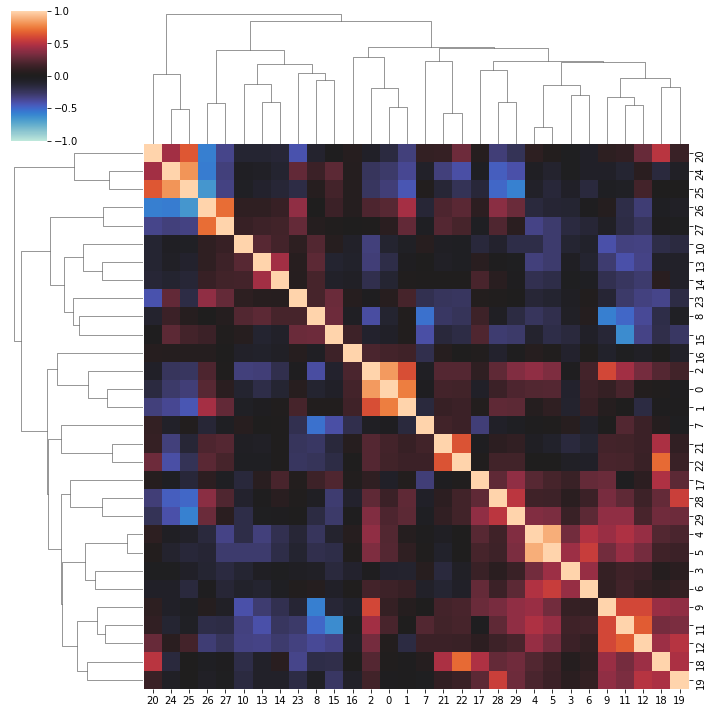

In [29]:
seaborn.clustermap(corr[indices, :][:, indices], vmin=-1, vmax=1, center=0)

In [ ]:
model = make_pipeline(
    RandomOverSampler(random_state=0),
    XGBClassifier(
        booster="gbtree",  
        objective="multi:softmax", 
        eval_metric="merror",
        tree_method="gpu_hist",
        use_label_encoder=False,
        subsample=0.9,
        n_estimators=1458,
        learning_rate=0.7,
        max_depth=7,
        colsample_bytree=1
    )
).fit(Xs_train[features], y_train)

In [ ]:
balanced_accuracy_score(model.predict(Xs_test), y_test)

In [141]:
r = permutation_importance(
    model, 
    Xs_test, y_test, 
    scoring="balanced_accuracy",
    n_jobs=32, n_repeats=10, 
    random_state=0
)

['feat_area_BF1',
 'feat_mean_BF1',
 'feat_mad_BF1',
 'feat_sum_SSC',
 'feat_mean_DAPI']

In [ ]:
with open(data_dir / "importance/pi.pickle", "wb") as fh:
    pickle.dump(fh, r)